In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')

# Cost of Decoupled Namespace

1 server 1 client

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

In [3]:
def mdtest(fname):
    with open(fname) as f:
        start = end = ""
        data = json.load(f)
        for line in data['stdout_lines']:
            if "started" in line: start = line.split()[4]
            if "finished" in line: end = line.split()[4]
        result = to_seconds(end) - to_seconds(start)
        if result < 0: return 0
        return result    

job,DeltaFS,BatchFS,POSIX (no stream),POSIX
nfile,,,,
1000.0,1.090002,1.458069,4.808571,9.617142
10000.0,2.443523,3.009065,38.359398,44.260844
100000.0,5.079124,6.426479,89.502994,103.742107


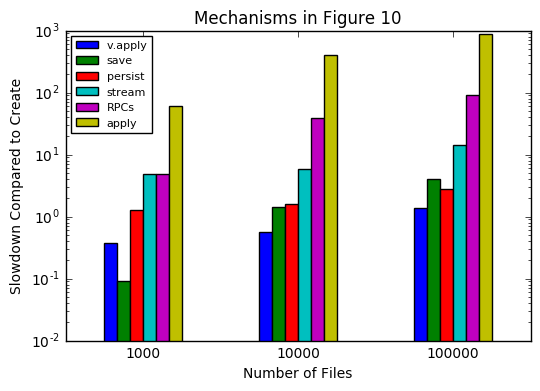

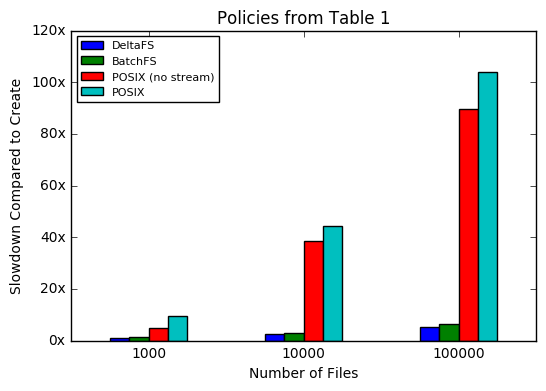

In [4]:
exp   = "experiments/fuse/batchfs/results-all/"
runs  = ["run0"] #, "run1", "run2", "run3"]
jobs  = ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']
files = ['1000', '10000', '100000']

# get nostream
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])
for nfiles in files:
    for s in ["stream", "nostream"]:
        for run in runs:
            # parse the events execution times
            expdir = exp
            expdir += '/results-' + run 
            expdir += '/' + nfiles 
            with open(expdir + '/summary-' + s + '.txt') as f:
                d = pd.read_csv(f, names=['job', 'time', 'delta'])
                d['rtime'] = d['delta'].apply(to_seconds)
                d['nfile'] = np.full(len(d), nfiles)
                del d['time'], d['delta']
                d['job'] = d['job'] + '-' + s + '-' + run
                df = df.append(d, ignore_index=True)
            # parse the RPCs execution times
            df.loc[len(df)] = ["RPCs-" + s + '-' + run] + [float(nfiles)] + [mdtest(expdir + '/summary-rpcs-' + s + '.txt')]

# massage into graphable format
df = df.pivot(index='nfile', values='rtime', columns='job')
for j in jobs:
    for s in ["stream", "nostream"]:
        job = j + '-' + s
        dfs = [job + '-' + r for r in runs]
        df[j + '-' + s] = df[dfs].mean(axis=1)#

# calculate the phase execution times
df['RPCs'] = df['RPCs-nostream']
df['stream'] = df['RPCs-stream'] - df['RPCs-nostream']
df['create'] = df['create-nostream']
df['save'] = df['save-nostream'] - df['create']
df['persist'] = df['persist-nostream'] - df['create']
df['v.apply'] = df['v.apply-nostream'] - df['create']
df['apply'] = df['apply-nostream'] - df['create']

# prune
creates = df['create']
slowdowns = df[['v.apply', 'save', 'persist', 'stream', 'RPCs', 'apply']]
slowdowns = slowdowns[:].div(creates, axis=0)

# graph slowdowns
plt.figure()
fig, ax = plt.subplots(1, 1)
slowdowns.plot.bar(ax=ax)
ax.set_title("Mechanisms in Figure 10")
ax.set_ylabel("Slowdown Compared to Create")
ax.legend(fontsize=8, loc='upper left')
#ax.set_ylim(0)
ax.set_xticklabels(files, rotation=0)
ax.set_xlabel("Number of Files")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
ax.set_yscale('log')

# graph policies
plt.figure()
fig, ax = plt.subplots(1, 1)
policies = df
policies['create'] = creates
policies['create+v.apply'] = creates + df['v.apply']
policies['POSIX (no stream)'] = df['RPCs']
policies['DeltaFS'] = creates + df['save']
policies['BatchFS'] = creates + df['save'] + df['v.apply']
policies['RPCs+save'] = df['RPCs'] + df['save']
policies['create+persist'] = creates + df['persist']
policies['create+persist+v.apply'] = creates + df['persist'] + df['v.apply']
policies['POSIX'] = df['RPCs'] + df['stream']

# normalize and graph
policies = policies[:].div(creates, axis=0)
policies = policies[['DeltaFS', 'BatchFS', 'POSIX (no stream)', 'POSIX']]
policies.plot.bar(ax=ax)
ax.set_ylim(0)
ax.set_title("Policies from Table 1")
ax.set_ylabel("Slowdown Compared to Create")
ax.legend(fontsize=8, loc='upper left')
ax.set_ylim(0)
ax.set_xticklabels(files, rotation=0)
ax.set_xlabel("Number of Files")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))

policies

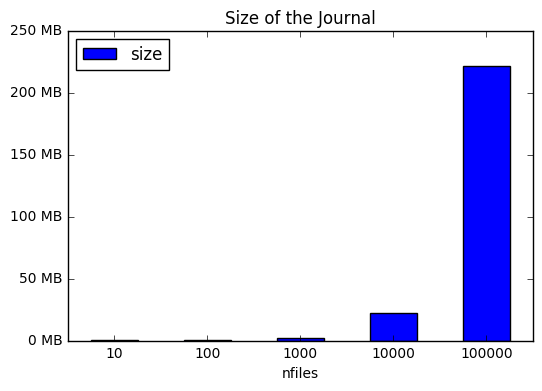

In [5]:
df = pd.DataFrame(columns=['nfiles', 'time', 'size'])

exp = "experiments/fuse/batchfs/results-all/results-run0/*/fsize.txt"
for fname in sorted(glob.glob(exp)):
    with open(fname) as f:
        d = pd.read_csv(f, names=['nfiles', 'time', 'size'])
        d['size'] = d['size']/(1024*1024)
        df = df.append(d, ignore_index=True)

df = df.drop_duplicates('nfiles')
fig, ax = plt.subplots(1, 1)
df.plot.bar(x='nfiles', y='size', ax=ax)
ax.set_title("Size of the Journal")
ax.set_xticklabels([10, 100, 1000, 10000, 100000], rotation=0)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f MB'))



job,DeltaFS,BatchFS,POSIX (no stream),POSIX
nfile,,,,
1000.0,1.090002,1.458069,4.808571,9.617142
10000.0,2.443523,3.009065,38.359398,44.260844
100000.0,5.079124,6.426479,89.502994,103.742107


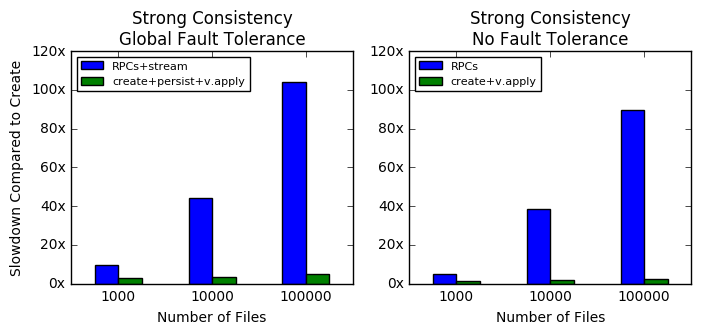

In [28]:
exp   = "experiments/fuse/batchfs/results-all/"
runs  = ["run0"] #, "run1", "run2", "run3"]
jobs  = ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']
files = ['1000', '10000', '100000']

# get nostream
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])
for nfiles in files:
    for s in ["stream", "nostream"]:
        for run in runs:
            # parse the events execution times
            expdir = exp
            expdir += '/results-' + run 
            expdir += '/' + nfiles 
            with open(expdir + '/summary-' + s + '.txt') as f:
                d = pd.read_csv(f, names=['job', 'time', 'delta'])
                d['rtime'] = d['delta'].apply(to_seconds)
                d['nfile'] = np.full(len(d), nfiles)
                del d['time'], d['delta']
                d['job'] = d['job'] + '-' + s + '-' + run
                df = df.append(d, ignore_index=True)
            # parse the RPCs execution times
            df.loc[len(df)] = ["RPCs-" + s + '-' + run] + [float(nfiles)] + [mdtest(expdir + '/summary-rpcs-' + s + '.txt')]

# massage into graphable format
df = df.pivot(index='nfile', values='rtime', columns='job')
for j in jobs:
    for s in ["stream", "nostream"]:
        job = j + '-' + s
        dfs = [job + '-' + r for r in runs]
        df[j + '-' + s] = df[dfs].mean(axis=1)#

# calculate the phase execution times
df['RPCs'] = df['RPCs-nostream']
df['stream'] = df['RPCs-stream'] - df['RPCs-nostream']
df['create'] = df['create-nostream']
df['save'] = df['save-nostream'] - df['create']
df['persist'] = df['persist-nostream'] - df['create']
df['v.apply'] = df['v.apply-nostream'] - df['create']
df['apply'] = df['apply-nostream'] - df['create']

# prune
creates = df['create']
slowdowns = df[['v.apply', 'save', 'persist', 'stream', 'RPCs', 'apply']]
slowdowns = slowdowns[:].div(creates, axis=0)

# graph fair comparisons
#plt.figure()
#fig, ax = plt.subplots(1, 1)
fair = df
fair['RPCs+stream'] = df['RPCs'] + df['stream']
fair['create+persist+v.apply'] = creates + df['persist'] + df['v.apply']
fair['create+v.apply'] = creates + df['v.apply']
fair['RPCs'] = df['RPCs']
#policies = df
#policies['create'] = creates
#policies['create+v.apply'] = creates + df['v.apply']
#policies['POSIX (no stream)'] = df['RPCs']
#policies['DeltaFS'] = creates + df['save']
#policies['BatchFS'] = creates + df['save'] + df['v.apply']
#policies['RPCs+save'] = df['RPCs'] + df['save']
#policies['create+persist'] = creates + df['persist']
#policies['create+persist+v.apply'] = creates + df['persist'] + df['v.apply']
#policies['POSIX'] = df['RPCs'] + df['stream']

# normalize and graph
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
fair = fair[:].div(creates, axis=0)
fair0 = fair[['RPCs+stream', 'create+persist+v.apply']]
fair1 = fair[['RPCs', 'create+v.apply']]
fair0.plot.bar(ax=ax[0])
fair1.plot.bar(ax=ax[1])

ax[0].set_title("Strong Consistency\nGlobal Fault Tolerance")
ax[1].set_title("Strong Consistency\nNo Fault Tolerance")
ax[0].set_ylabel("Slowdown Compared to Create")
for i in [0, 1]:
    ax[i].set_ylim(0)
    ax[i].legend(fontsize=8, loc='upper left')
    ax[i].set_ylim(0, 120)
    ax[i].set_xticklabels(files, rotation=0)
    ax[i].set_xlabel("Number of Files")
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))

policies